<center><font size = "10"> Week 8 - Synapses <center>
<center><font size = "8">Home work - Solutions<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number:
<br>Group member1:
<br>Group member2:
<br>Group member3:
    
__IMPORTANT:__<font size = "3"> Exercises in <font color='red'>red</font> are mandatory assignements to be delivered by next Monday before 23:59.

## Optional: Plot the dependence of the NMDA conductance on the Mg2+ concentration.

<font sie='3'>Create a single compartmental soma neuron to host the synpase modeled in SimpleAMPA_NMDA.mod file. Using the stimulation pattern and the values for the synaptic conductances used in tutorial 01, plot the NMDA conductance at different mM [Mg2+] values. Select appropiate values to explore the dynamics. 
    
<font sie='3'> What happens to the NMDA conducatance in relation to Mg2+? What is the functional purpose of this behaviour?

# <font color= 'red'>Ex 1:</font>  Configure a facilitating synapse (E1)
    
<font size='3'> Create a single compartmental soma neuron, add to it passive properties, add to the center of the neuron a synapse with the mechanism modeled in TsodyksMarkram_AMPA_NMDA.mod file, inject a stimulation pattern and define the conductances for NMDA and AMPA receptors, as it was done in tutorial 02. 

<font size='3'>Find the values for `U1`, `tau_rec` and `tau_facil` that would make the synapse behave as a facilitating synapse and plot the `R`, `Use` and conductance curves. Write a definition of `U1`, `tau_rec` and `tau_facil`.
    
<font size='3'>Plot comparison (histograms) between the three parameters in three types on synapses (facilitating, depressing and pseudolinear from Tutorial 2) and briefly interpret them. Is there relationship between the parameters and variables depending on the synapse type?
    
 
    
<font size='3'><font color= 'red'>[1.5 pts]</font>

# <font color= 'red'>Ex 2:</font>  Compute EPSP's Features: amplitudes, latencies, tau rise and Coefficient of Variation (CV) of the EPSP amplitudes 

<font size='3'>Compute the amplitudes, latencies and tau rise of the excitatory postsynaptic potential (EPSP) of the three connections traces provided for your group (.h5 files you can find in the group folder). Visualize the mean values and standard deviations of this features.


<font size='3'>Then compute the coefficient of variation of EPSP amplitudes for each of the connections and the mean CV profile between them. Visualize your results in two plots:
- mean CV profiles: the plot should have four curves, one per each connection and one for the mean
- raster plot of CV of EPSP amplitudes as a function of EPSP amplitudes (all EPSPS, not only the first one)

<font size='3'>Both plots should look similar to the ones in the paper show in the lecture [Barros-Zulaica et al., 2019](https://www.ncbi.nlm.nih.gov/pubmed/31680928). 
    
<font size='3'>*Hint: Be careful with which plot should have a standard deviations*

<font size='3'><font color= 'red'>[2.5 pts]</font>

# <font color='red'>Ex 3:</font> Compute failure rate

<font size='3'>Compute the failure rate of the EPSPs from the connections of your group folder. The failure rate is the fraction of trials from which no PSP is generated above certain threshold. You can find a way of computing the failure rate in [Feldmeyer et al., 1999](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269646/). Make sure to test for failure based both latency and amplitude size. Necessary noise can be extracted from the initial part of the simulation, before any stimulus arrives. 

    
<font size='3'>Represent the mean result of the three connections in a bar plot. For each connection visualize the distributions of the EPSPs amplitudes with split between the success and failure cases.  

<font size='3'><font color= 'red'>[2 pts]</font>

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_c10 = h5py.File("Group5/Group5/connection_c10.h5", "r")
data_c64 = h5py.File("Group5/Group5/connection_c64.h5", "r")
data_c77 = h5py.File("Group5/Group5/connection_c77.h5", "r")
data = [data_c10, data_c64, data_c77];
data_names = ["c10", "c64","c77"]

In [3]:
traces = [];
mean_traces = [];
for d in data:
    trace_d = [];
    for key in d.keys():
        trace_d.append(d.get(key));
        
    mean_trace_d = np.mean(trace_d,axis=0)
    
    traces.append(trace_d)
    mean_traces.append(mean_trace_d)
time = np.arange(0, 1.3, 0.0001)

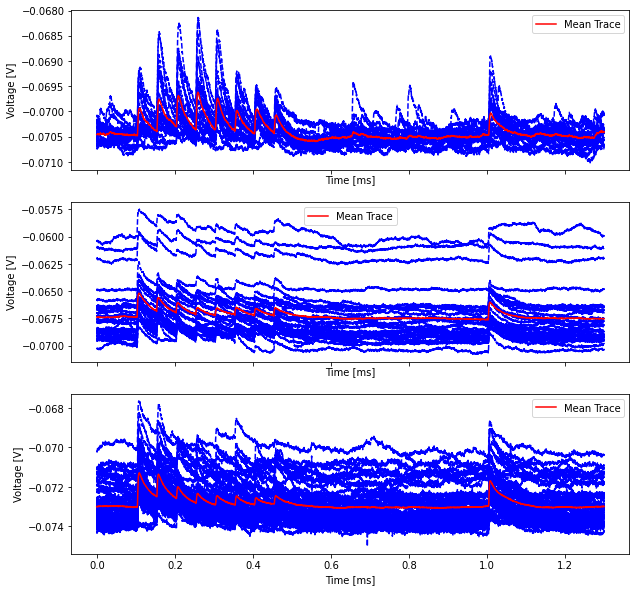

In [4]:
fig, ax = plt.subplots(len(data), 1, figsize=(10, 10), sharex=True)
for d in range(len(data)):
    for trace in traces[d]:
        ax[d].plot(time,trace,"b--")
    ax[d].plot(time,mean_traces[d],"r",label = "Mean Trace")
    ax[d].legend()
    ax[d].set_ylabel("Voltage [V]")
    ax[d].set_xlabel("Time [ms]");

In [5]:
def extract_PSP_window(trace, time, stimulation_index, time_before=50, time_after=300):
    """Extract a time window with a single EPSP trace"""
    psp_trace = trace[stimulation_index - time_before : stimulation_index + time_after]
    psp_time = time[stimulation_index - time_before : stimulation_index + time_after]

    return psp_trace, psp_time
def extract_baseline_noise(trace,first_stimulation_index = 1000):
    init_trace = trace[0:first_stimulation_index]
    baseline_noise = np.std(init_trace)
    return baseline_noise

In [6]:
def extract_EPSP_features(psp_trace, psp_time, stimulation_time):
    """
    Function takes in a EPSP curve and calculates the following features: amplitude;
    5%, 20% and 80% of the amplitude, tau rise and latency. Based on defintions from
    Feldmeyer et al., 1999.

    Parameters
    ----------
    psp_trace : array with voltage trace [mV]
    psp_time : array of psp times [s]
    stimulation_time : time of the stimulation [s]

    Returns
    -------
    psp_percent : dictionary with psp amplitudes at 5%, 20% and 80% of the amplitude
    times : dictionary with psp times at 5%, 20% and 80% of the amplitude
    amplitude : amplitude of the first EPSP computed as the difference between the 20 and the 80 % of rise
    tau_rise : distance between the time of 20% and 80% of the rise of the EPSP [s]
    latency : time between the AP of the presynaptic cell and 5% amplitude rise of the EPSP [s]
    """

    # find absolute values of the psp trace
    max_psp = np.max(psp_trace)
    min_psp = np.min(psp_trace)
    amplitude_psp = np.abs(max_psp - min_psp)

    # compute percentages of amplitudes
    twenty_amplitude = amplitude_psp * 80.0 / 100.0
    eighty_amplitude = amplitude_psp * 20.0 / 100.0
    five_amplitude = amplitude_psp * 95.0 / 100.0
    amplitude = twenty_amplitude - eighty_amplitude

    # compute amplitude percentages on the psp trace
    psp_percent = {
        "five": -(five_amplitude - max_psp),
        "twenty": -(twenty_amplitude - max_psp),
        "eighty": -(eighty_amplitude - max_psp),
    }

    # find corresponding index of an array
    five_index = np.where(psp_trace >= psp_percent["five"])[0][0]
    twenty_index = np.where(psp_trace >= psp_percent["twenty"])[0][0]
    eighty_index = np.where(psp_trace >= psp_percent["eighty"])[0][0]

    # extract time points for percentage points of the trace
    psp_times = {
        "five": psp_time[five_index],
        "twenty": psp_time[twenty_index],
        "eighty": psp_time[eighty_index],
    }

    # calculate time features of a PSP
    tau_rise = np.abs((psp_times["twenty"] - psp_times["eighty"]))
    latency = np.abs((psp_times["five"]) - stimulation_time)

    return psp_percent, psp_times, amplitude, tau_rise, latency;

In [7]:
#Failures were defined as events with amplitudes less than 1·5 × noise and/or latencies larger than 2·5 × the mean latency.
def failure(amplitude, latency, baseline_noise, mean_latency):
    return (amplitude < 1.5*baseline_noise or latency > 2.5*mean_latency)

In [8]:
stimulation_indices = np.array([1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 10000])

In [9]:
#Computing amplitudes and latencies:
amplitudes = [];
latencies  = [];
for d in range(len(data)):
    amplitudes_d = [];
    latencies_d  = [];
    for stimulation_index in stimulation_indices:
        amplitudes_stim = [];
        latencies_stim  = [];
        for trace in traces[d]:
            psp_trace, psp_time = extract_PSP_window(trace,time,stimulation_index)
            _ , _ , amplitude, _ , latency = extract_EPSP_features(psp_trace, psp_time, time[stimulation_index])
            amplitudes_stim.append(amplitude)
            latencies_stim.append(latency)
            
        amplitudes_d.append(amplitudes_stim)
        latencies_d.append(latencies_stim)
    
    amplitudes.append(amplitudes_d)
    latencies.append(latencies_d)   

In [10]:
print(len(latencies[0]))

9


In [11]:
#Computing Baseline Noises and Mean Latencies
baseline_noises = []
mean_latencies  = [] # means accross trials for a givn stimulus at a given connection
for d in range(len(data)):
    baseline_noises_d = []
    for trace in traces[d]:
        bn = extract_baseline_noise(trace,stimulation_indices[0])
        baseline_noises_d.append(bn)
    baseline_noises.append(baseline_noises_d)
    
for d in range(len(data)):
    mean_latencies_d  = []
    for s in range(len(stimulation_indices)):
        ml = np.mean(latencies[d][s])
        mean_latencies_d.append(ml)
    
    mean_latencies.append(mean_latencies_d)

In [12]:
print(len(mean_latencies[0]))
print(len(baseline_noises[0]))

9
20


In [13]:
#Decide Failures

Failures = [];
amplitudes_over_baseline_noise = []
for d in range(len(amplitudes)):
    f_d = [];
    a_d = [];
    for s in range(len(amplitudes[d])):
        f_ds = [];
        for t in range(len(amplitudes[d][s])):
            f_dst = failure(amplitudes[d][s][t],latencies[d][s][t],baseline_noises[d][t],mean_latencies[d][s])
            a_dst = amplitudes[d][s][t]/baseline_noises[d][t];
            
            f_ds.append(f_dst)
            a_d.append(a_dst)
            
        f_d.append(f_ds)
        
    Failures.append(f_d)
    amplitudes_over_baseline_noise.append(a_d)

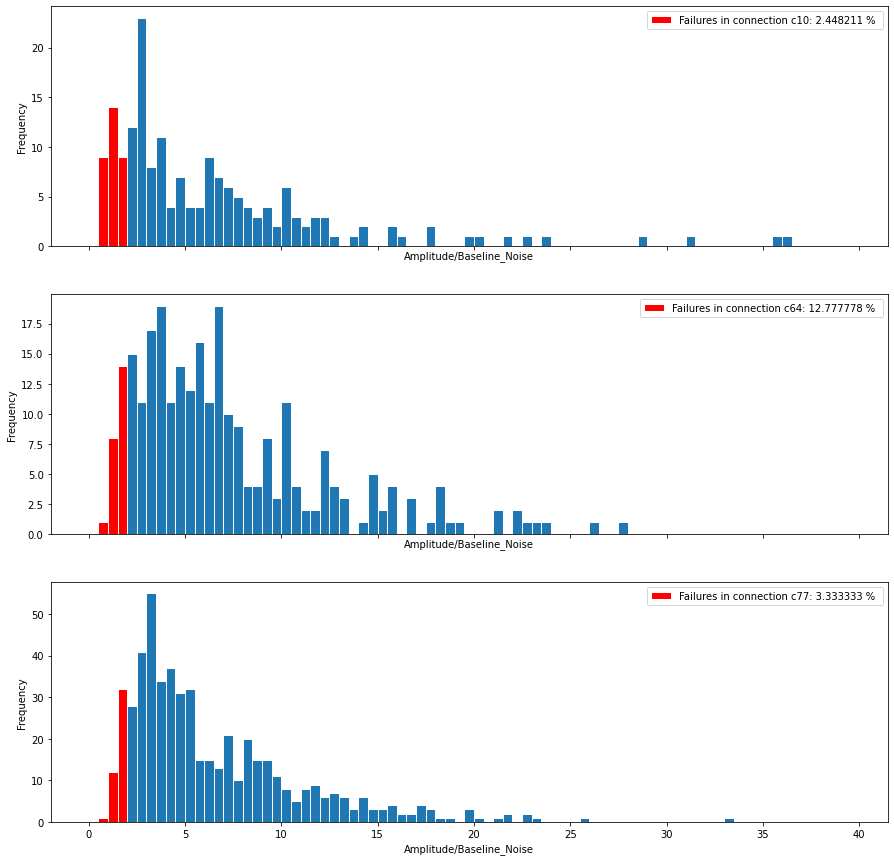

In [58]:
fig, ax = plt.subplots(len(data), 1, figsize=(15,15), sharex=True)
for d in range(len(data)):
    my_bins = np.arange(0, 40, 0.5)
    N, bins, patches = ax[d].hist(amplitudes_over_baseline_noise[d],bins = my_bins,edgecolor = 'w',label = "Failures in connection %s: %f %% "%(data_names[d],sum(N[0:3])*100/sum(N)))
    i = 0
    while (my_bins[i] <= 1.5):
        patches[i].set_facecolor('r')
        i = i+1
    ax[d].legend()
    ax[d].set_ylabel("Frequency")
    ax[d].set_xlabel("Amplitude/Baseline_Noise");
plt.show()

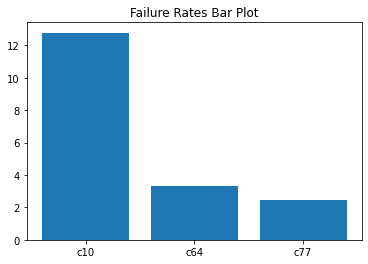

In [60]:
Failure_Rates = [0. , 0., 0.];
for d in range(len(Failures)):
    N_stim = len(Failures[d]);
    for s in range(N_stim):
        N_trace = len(Failures[d][s])
        for t in range(N_trace):
            if Failures[d][s][t]:                
                Failure_Rates[d] = Failure_Rates[d] + 100/(N_stim*N_trace)

plt.bar(data_names,height=Failure_Rates)
plt.title("Failure Rates Bar Plot")
plt.show()